In [1]:
## 라이브러리 호출

import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, Conv2D, Activation,MaxPooling2D, BatchNormalization
from tensorflow.keras.applications import MobileNetV2, xception,ResNet50, EfficientNetB0, VGG16, InceptionV3,InceptionResNetV2
from tensorflow.keras.optimizers import Adam
from keras import optimizers
from keras.models import load_model

2022-11-23 22:56:15.731839: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-23 22:56:15.910056: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-23 22:56:15.948941: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-23 22:56:16.576044: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

# 파일불러오기

In [2]:
## 제출파일

sub = pd.read_csv('/home/hahaha503/CH/인기활/cnn/5-flowers-image-classification/Sample_submission.csv')
sub

,id,label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
395,396,0
396,397,0
397,398,0
398,399,0


In [3]:
## flow_from_directory, flow_from_dataframe 사용을 위한 파일 경로 설정

train_dir = '/home/hahaha503/CH/인기활/cnn/5-flowers-image-classification/train/'
test_dir = '/home/hahaha503/CH/인기활/cnn/5-flowers-image-classification/test/'

In [4]:
## test_dataframe 형성

test_df = pd.DataFrame()
test_df['file'] = os.listdir(test_dir)
test_df

,file
0,99.jpg
1,98.jpg
2,97.jpg
3,96.jpg
4,95.jpg
...,...
395,102.jpg
396,101.jpg
397,100.jpg
398,10.jpg


In [17]:
## ImageDataGenerator을 사용해 train,test,validation 설정

# Data Agumentation 을 위해 horizontal_flip, vertical_flip, shear_range, zoom_range,rotation_range, width_shift_range,height_shift_range, fill_mode 설정
train_igen = ImageDataGenerator(horizontal_flip=True,
                                vertical_flip=True,
                                rescale=1. / 255,
                                validation_split=0.1,
                                shear_range=0.1,
                                zoom_range=0.1,
                                rotation_range=30,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                fill_mode='nearest')

# validation 은 어떠한 데이터 변형도 없어야한다.
val_igen = ImageDataGenerator(rescale=1. / 255,
                                validation_split=0.1)
                                                               
test_igen = ImageDataGenerator(rescale = 1/255)
isize = (300,300)
ishape = (300,300,3)
bs = 32

In [18]:
train = train_igen.flow_from_directory(directory= train_dir, target_size = isize, class_mode = 'categorical',shuffle= True,seed=42, batch_size = bs, subset='training')
val = val_igen.flow_from_directory(directory= train_dir, target_size = isize, class_mode = 'categorical', shuffle= True,seed=42,batch_size = bs, subset='validation')
test = test_igen.flow_from_dataframe(test_df, directory = test_dir, target_size= isize, x_col='file', y_col=None, class_mode=None, shuffle=False)


Found 3480 images belonging to 5 classes.
Found 385 images belonging to 5 classes.
Found 400 validated image filenames.


# 이미지 확인

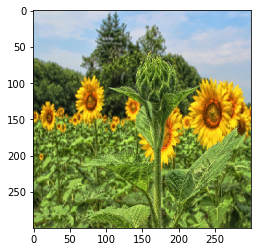

[0. 0. 0. 1. 0.]


In [59]:
import numpy as np
imags, labels= [],[]
for i in range(5):
    a, b = val.next()
    imags.extend(a)
    labels.extend(b)

img = np.asarray(imags)
label= np.asarray(labels)

plt.imshow(img[14])
plt.show()
print(label[14])

데이지 1
민들레 2
장미 3
해바라기 4
튤립 5 




# Modeling

In [7]:
## 서버 GPU 사용하기 위한 코드

import os
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # 사용할 GPU

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=18000)]) # 사용할 용량
  except RuntimeError as e:
    print(e)

## Model - InceptionV3 사용

In [19]:
base = InceptionV3(include_top=False, weights='imagenet', input_shape=ishape)
base.trainable = False

In [20]:
model = Sequential([base,
                    GlobalAveragePooling2D(),
                    Dropout(0.15),
                    Dense(512,activation='relu',kernel_initializer='he_normal'),
                    BatchNormalization(),
                    Dense(256, activation='relu',kernel_initializer='he_normal'),
                    Dropout(0.3),
                    Dense(128, activation='relu',kernel_initializer='he_normal'),
                    Dropout(0.3),
                    Dense(64, activation='relu',kernel_initializer='he_normal'),
                    Dense(5, activation='softmax',kernel_initializer='he_normal')])

opt = optimizers.Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])


In [22]:
filepath = './total/inception_1_{epoch:02d}_val_acc_{val_accuracy:.2f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',
                            verbose = 1, save_best_only = True, mode ='max')
                            
callback = [checkpoint]

history = model.fit_generator(train, epochs= 50, steps_per_epoch= 3480//32,
                            validation_data = val, validation_steps = 385//32, callbacks=callback)

/tmp/ipykernel_97961/563710109.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train, epochs= 50, steps_per_epoch= 3480//32,


Epoch 1/50
108/108 [==============================] - ETA: 0s - loss: 0.4503 - accuracy: 0.8393
Epoch 1: val_accuracy improved from -inf to 0.85417, saving model to ./total/inception_1_01_val_acc_0.85.h5
108/108 [==============================] - 60s 552ms/step - loss: 0.4503 - accuracy: 0.8393 - val_loss: 0.3959 - val_accuracy: 0.8542
Epoch 2/50
108/108 [==============================] - ETA: 0s - loss: 0.4331 - accuracy: 0.8524
Epoch 2: val_accuracy improved from 0.85417 to 0.88021, saving model to ./total/inception_1_02_val_acc_0.88.h5
108/108 [==============================] - 59s 545ms/step - loss: 0.4331 - accuracy: 0.8524 - val_loss: 0.3689 - val_accuracy: 0.8802
Epoch 3/50
108/108 [==============================] - ETA: 0s - loss: 0.3927 - accuracy: 0.8579
Epoch 3: val_accuracy did not improve from 0.88021
108/108 [==============================] - 58s 541ms/step - loss: 0.3927 - accuracy: 0.8579 - val_loss: 0.3966 - val_accuracy: 0.8802
Epoch 4/50
108/108 [====================

### inceptionV3 미세조정

In [45]:
inception = load_model('./total/inception_1_46_val_acc_0.91.h5')

## base모델의 상단 30층부터 학습 가능하게 미세 조정
for layers in inception.layers[0].layers[:-20]:
    layers.trainable = False

for layers in inception.layers[0].layers[-20:]:
    layers.trainable = True
    
for layers in inception.layers[1:]:
    layers.trainable = True

    
opt = optimizers.Adam(learning_rate=0.0005)

inception.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])


history_inception = inception.fit_generator(train, epochs=5 , steps_per_epoch= 3480//32,
                            validation_data = val, validation_steps = 385//32, callbacks=callback)

/tmp/ipykernel_97961/1055248022.py:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_inception = inception.fit_generator(train, epochs=5 , steps_per_epoch= 3480//32,


Epoch 1/5
108/108 [==============================] - ETA: 0s - loss: 0.3246 - accuracy: 0.8910
Epoch 1: val_accuracy did not improve from 0.91406
108/108 [==============================] - 65s 572ms/step - loss: 0.3246 - accuracy: 0.8910 - val_loss: 0.7570 - val_accuracy: 0.8542
Epoch 2/5
108/108 [==============================] - ETA: 0s - loss: 0.2179 - accuracy: 0.9252
Epoch 2: val_accuracy did not improve from 0.91406
108/108 [==============================] - 60s 559ms/step - loss: 0.2179 - accuracy: 0.9252 - val_loss: 0.4509 - val_accuracy: 0.8724
Epoch 3/5
108/108 [==============================] - ETA: 0s - loss: 0.1698 - accuracy: 0.9417
Epoch 3: val_accuracy did not improve from 0.91406
108/108 [==============================] - 62s 570ms/step - loss: 0.1698 - accuracy: 0.9417 - val_loss: 0.4113 - val_accuracy: 0.8906
Epoch 4/5
108/108 [==============================] - ETA: 0s - loss: 0.1664 - accuracy: 0.9405
Epoch 4: val_accuracy did not improve from 0.91406
108/108 [=====

## Model- VGG 16 사용

In [24]:
base1 = VGG16(include_top=False, weights='imagenet', input_shape=ishape)
base1.trainable = False

model1 = Sequential([base1,
                    GlobalAveragePooling2D(),
                    Dropout(0.15),
                    Dense(512,activation='relu',kernel_initializer='he_normal'),
                    BatchNormalization(),
                    Dense(256, activation='relu',kernel_initializer='he_normal'),
                    Dropout(0.3),
                    Dense(128, activation='relu',kernel_initializer='he_normal'),
                    Dropout(0.3),
                    Dense(64, activation='relu',kernel_initializer='he_normal'),
                    Dense(5, activation='softmax',kernel_initializer='he_normal')])
opt = optimizers.Adam(learning_rate=0.001)

model1.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

filepath = './ensemble/first_{epoch:02d}_val_acc_{val_accuracy:.2f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',
                            verbose = 1, save_best_only = True, mode ='max')
                            
callback = [checkpoint]

history1 = model1.fit_generator(train, epochs= 60, steps_per_epoch= 3480//32,
                            validation_data = val, validation_steps = 385//32, callbacks=callback)


/tmp/ipykernel_97961/2350447379.py:26: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1 = model1.fit_generator(train, epochs= 60, steps_per_epoch= 3480//32,


Epoch 1/60
108/108 [==============================] - ETA: 0s - loss: 1.3405 - accuracy: 0.4797
Epoch 1: val_accuracy improved from -inf to 0.72396, saving model to ./ensemble/first_01_val_acc_0.72.h5
108/108 [==============================] - 65s 561ms/step - loss: 1.3405 - accuracy: 0.4797 - val_loss: 1.0054 - val_accuracy: 0.7240
Epoch 2/60
108/108 [==============================] - ETA: 0s - loss: 0.9815 - accuracy: 0.6267
Epoch 2: val_accuracy improved from 0.72396 to 0.78125, saving model to ./ensemble/first_02_val_acc_0.78.h5
108/108 [==============================] - 59s 544ms/step - loss: 0.9815 - accuracy: 0.6267 - val_loss: 0.8160 - val_accuracy: 0.7812
Epoch 3/60
108/108 [==============================] - ETA: 0s - loss: 0.8685 - accuracy: 0.6697
Epoch 3: val_accuracy did not improve from 0.78125
108/108 [==============================] - 58s 535ms/step - loss: 0.8685 - accuracy: 0.6697 - val_loss: 0.6672 - val_accuracy: 0.7760
Epoch 4/60
108/108 [==========================

### VGG16 미세조정

In [46]:
vgg = load_model('first_22_val_acc_0.87.h5')

# base모델의 상단 3층부터 학습 가능하게 미세 조정
for layers in vgg.layers[0].layers[:-2]:
    layers.trainable = False

for layers in vgg.layers[0].layers[-2:]:
    layers.trainable = True
    
for layers in vgg.layers[1:]:
    layers.trainable = True

    
opt = optimizers.Adam(learning_rate=0.00001)

vgg.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])


history_vgg = vgg.fit_generator(train, epochs=5 , steps_per_epoch= 3480//32,
                            validation_data = val, validation_steps = 385//32, callbacks=callback)

/tmp/ipykernel_97961/1897027371.py:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_vgg = vgg.fit_generator(train, epochs=5 , steps_per_epoch= 3480//32,


Epoch 1/5
108/108 [==============================] - ETA: 0s - loss: 0.4112 - accuracy: 0.8402
Epoch 1: val_accuracy did not improve from 0.91406
108/108 [==============================] - 61s 558ms/step - loss: 0.4112 - accuracy: 0.8402 - val_loss: 0.4317 - val_accuracy: 0.8646
Epoch 2/5
108/108 [==============================] - ETA: 0s - loss: 0.3808 - accuracy: 0.8570
Epoch 2: val_accuracy did not improve from 0.91406
108/108 [==============================] - 62s 570ms/step - loss: 0.3808 - accuracy: 0.8570 - val_loss: 0.4427 - val_accuracy: 0.8542
Epoch 3/5
108/108 [==============================] - ETA: 0s - loss: 0.3568 - accuracy: 0.8675
Epoch 3: val_accuracy did not improve from 0.91406
108/108 [==============================] - 60s 554ms/step - loss: 0.3568 - accuracy: 0.8675 - val_loss: 0.4249 - val_accuracy: 0.8646
Epoch 4/5
108/108 [==============================] - ETA: 0s - loss: 0.3424 - accuracy: 0.8692
Epoch 4: val_accuracy did not improve from 0.91406
108/108 [=====

## Model - MobileNetV2 사용

In [26]:
base2 = MobileNetV2(include_top=False, weights='imagenet', input_shape=ishape)
base2.trainable = False

model2 = Sequential([base2,
                    GlobalAveragePooling2D(),
                    Dropout(0.15),
                    Dense(512,activation='relu',kernel_initializer='he_normal'),
                    BatchNormalization(),
                    Dense(256, activation='relu',kernel_initializer='he_normal'),
                    Dropout(0.3),
                    Dense(128, activation='relu',kernel_initializer='he_normal'),
                    Dropout(0.3),
                    Dense(64, activation='relu',kernel_initializer='he_normal'),
                    Dense(5, activation='softmax',kernel_initializer='he_normal')])

opt = optimizers.Adam(learning_rate=0.001)

model2.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

filepath = './ensemble/third_{epoch:02d}_val_acc_{val_accuracy:.2f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',
                            verbose = 1, save_best_only = True, mode ='max')
                            
callback = [checkpoint]

history2 = model2.fit_generator(train, epochs= 60, steps_per_epoch= 3480//32,
                            validation_data = val, validation_steps = 385//32, callbacks=callback)


/tmp/ipykernel_97961/3662078466.py:27: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = model2.fit_generator(train, epochs= 60, steps_per_epoch= 3480//32,


Epoch 1/60
108/108 [==============================] - ETA: 0s - loss: 0.8494 - accuracy: 0.6865
Epoch 1: val_accuracy improved from -inf to 0.84375, saving model to ./ensemble/third_01_val_acc_0.84.h5
108/108 [==============================] - 59s 517ms/step - loss: 0.8494 - accuracy: 0.6865 - val_loss: 0.4517 - val_accuracy: 0.8438
Epoch 2/60
108/108 [==============================] - ETA: 0s - loss: 0.5448 - accuracy: 0.7996
Epoch 2: val_accuracy improved from 0.84375 to 0.86458, saving model to ./ensemble/third_02_val_acc_0.86.h5
108/108 [==============================] - 57s 530ms/step - loss: 0.5448 - accuracy: 0.7996 - val_loss: 0.4397 - val_accuracy: 0.8646
Epoch 3/60
108/108 [==============================] - ETA: 0s - loss: 0.4622 - accuracy: 0.8350
Epoch 3: val_accuracy did not improve from 0.86458
108/108 [==============================] - 56s 521ms/step - loss: 0.4622 - accuracy: 0.8350 - val_loss: 0.4156 - val_accuracy: 0.8385
Epoch 4/60
108/108 [==========================

## mobilenetv2 미세조정(Fine Tuning)

In [52]:

mobile = load_model('third92_val_acc_0.91.h5')

## base모델의 상단 30층부터 학습 가능하게 미세 조정
for layers in mobile.layers[0].layers[:-10]:
    layers.trainable = False

for layers in mobile.layers[0].layers[-10:]:
    layers.trainable = True
    
for layers in mobile.layers[1:]:
    layers.trainable = True

    
opt = optimizers.Adam(learning_rate=0.001)

mobile.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])


history_mobile = mobile.fit_generator(train, epochs=50 , steps_per_epoch= 3480//32,
                            validation_data = val, validation_steps = 385//32, callbacks=callback)

/tmp/ipykernel_97961/3210521000.py:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_mobile = mobile.fit_generator(train, epochs=50 , steps_per_epoch= 3480//32,


Epoch 1/50
108/108 [==============================] - ETA: 0s - loss: 0.1864 - accuracy: 0.9530
Epoch 1: val_accuracy did not improve from 0.91406
108/108 [==============================] - 61s 550ms/step - loss: 0.1864 - accuracy: 0.9530 - val_loss: 0.6459 - val_accuracy: 0.8724
Epoch 2/50
108/108 [==============================] - ETA: 0s - loss: 0.1366 - accuracy: 0.9582
Epoch 2: val_accuracy did not improve from 0.91406
108/108 [==============================] - 58s 541ms/step - loss: 0.1366 - accuracy: 0.9582 - val_loss: 0.6435 - val_accuracy: 0.9062
Epoch 3/50
108/108 [==============================] - ETA: 0s - loss: 0.1220 - accuracy: 0.9606
Epoch 3: val_accuracy did not improve from 0.91406
108/108 [==============================] - 58s 538ms/step - loss: 0.1220 - accuracy: 0.9606 - val_loss: 0.7502 - val_accuracy: 0.8724
Epoch 4/50
108/108 [==============================] - ETA: 0s - loss: 0.1195 - accuracy: 0.9588
Epoch 4: val_accuracy did not improve from 0.91406
108/108 [=

## CNN 모델

In [54]:
cnn_model = tf.keras.models.Sequential()

cnn_model.add(tf.keras.layers.InputLayer(input_shape=(256,256,3,))) 
cnn_model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu')) 
cnn_model.add(Dropout(0.2))
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2))) 
cnn_model.add(tf.keras.layers.BatchNormalization()) 

cnn_model.add(tf.keras.layers.Conv2D(256, kernel_size=(3,3), strides = (1,1), activation='relu')) 
cnn_model.add(Dropout(0.2))
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2))) 
cnn_model.add(tf.keras.layers.BatchNormalization()) 

cnn_model.add(tf.keras.layers.Conv2D(256, kernel_size=(3,3), strides = (1,1), activation='relu')) 
cnn_model.add(Dropout(0.2))
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2))) 
cnn_model.add(tf.keras.layers.BatchNormalization()) 

cnn_model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu')) 
cnn_model.add(Dropout(0.2))
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2))) 
cnn_model.add(tf.keras.layers.GlobalMaxPool2D()) 

cnn_model.add(tf.keras.layers.Flatten()) 
cnn_model.add(tf.keras.layers.Dense(128, activation='relu'))
cnn_model.add(tf.keras.layers.Dropout(0.2)) 
cnn_model.add(tf.keras.layers.Dense(64, activation='relu'))
cnn_model.add(tf.keras.layers.BatchNormalization()) 

cnn_model.add(tf.keras.layers.Dense(5, activation='softmax')) 

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()
#history= cnn_model.fit(train , epochs = 180, steps_per_epoch=3094//32, validation_data=val, validation_steps=771//32)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_188 (Conv2D)         (None, 254, 254, 128)     3584      
                                                                 
 dropout_15 (Dropout)        (None, 254, 254, 128)     0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 127, 127, 128)    0         
 2D)                                                             
                                                                 
 batch_normalization_192 (Ba  (None, 127, 127, 128)    512       
 tchNormalization)                                               
                                                                 
 conv2d_189 (Conv2D)         (None, 125, 125, 256)     295168    
                                                                 
 dropout_16 (Dropout)        (None, 125, 125, 256)    

## Ensemble 기법 적용

In [28]:
inception_pred = model.predict(test)
vgg_pred = model1.predict(test)
mobile_pred = model2.predict(test)


13/13 [==============================] - 2s 121ms/step


In [29]:
## 각 모델들의 확률을 더함

pred_list = [inception_pred,vgg_pred,mobile_pred]
pred_sum = np.sum(np.array(pred_list),axis=0)
outcome = np.argmax(pred_sum,axis=1)
outcome

## test의 파일명에서 id만 뽑기 위한 함수 생성, 적용
def onlyfile(x):
    data = x[:-4]
    return data

a = list(map(onlyfile,test.filenames))

## 이후 id와 label값 적용
df = pd.DataFrame({'id':a, 'label':outcome})

## 최종 제출파일 저장
df['id'] = df['id'].apply(int)
total = pd.merge(sub,df,how='inner',on='id')
total.drop(['label_x'],axis=1 ,inplace=True)
total.columns = ['id','label']
total.to_csv('ensemble_v2.csv', index=False)

# Test 파일 만들기

In [27]:
## Predict 파일 만들기
data = total_model.predict(test)

## argmax() 함수를 통해 가장 높은 값의 위치 반환
label = []
for i in data:
    label.append(i.argmax())

## test의 파일명에서 id만 뽑기 위한 함수 생성 및 적용
def onlyfile(x):
    data = x[:-4]
    return data

a = list(map(onlyfile,test.filenames))

## 이후 id와 label값 적용
df = pd.DataFrame({'id':a, 'label':label})

## 분류값이 0~4까지 있는지 확인

df['label'].unique()

## 정수화
df['id'] = df['id'].apply(int)

13/13 [==============================] - 2s 113ms/step


In [72]:
## 최종 제출파일 저장
df['id'] = df['id'].apply(int)
total = pd.merge(sub,df,how='inner',on='id')
total.drop(['label_x'],axis=1 ,inplace=True)
total.columns = ['id','label']
total.to_csv('fine_tuningv5.csv', index=False)